---
title: "Parameter Estimation"
subtitle: "BMES 678: Programming Assignment"
author: "Tony Kabilan Okeke"
format: PrettyPDF-pdf
---

In [1]:
%load_ext autoreload
%autoreload 2

from scipy.interpolate import pchip_interpolate
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
import json
import time

In [2]:
def style_axis(
    ax: plt.axes,
    xlab: str = "",
    ylab: str = "",
    xgrid: bool = True,
    ygrid: bool = True,
    lab_size: int = 11,
) -> None:
    ax.minorticks_on()
    ax.spines[["top", "right"]].set_visible(False)

    if xlab:
        ax.set_xlabel(xlab, fontsize=lab_size)
    if ylab:
        ax.set_ylabel(ylab, fontsize=lab_size)

    if xgrid:
        ax.xaxis.grid(True, which="major", color="gray", alpha=0.6, linewidth=0.5)
        ax.xaxis.grid(
            True, which="minor", color="gray", alpha=0.6, linewidth=0.2, linestyle="--"
        )
    if ygrid:
        ax.yaxis.grid(True, which="major", color="gray", alpha=0.6, linewidth=0.5)
        ax.yaxis.grid(
            True, which="minor", color="gray", alpha=0.6, linewidth=0.2, linestyle="--"
        )


def plot_results(soln, experimental):
    """Plot the results of the simulation and the experimental data"""
    colors = ["#ff6361", "#ffa600"]
    lines = ["-", "--"]

    t, Y = soln

    fig, ax = plt.subplots(figsize=(5, 4))
    style_axis(ax, "Time", "Concentration")
    ax.plot(t, Y[:, 0], label="G [simulation]", color=colors[0], linestyle=lines[0])
    ax.plot(
        experimental[:, 0],
        experimental[:, 1],
        label="G [experiment]",
        color=colors[0],
        linestyle=lines[1],
    )
    ax.plot(t, Y[:, 1], label="ATP [simulation]", color=colors[1], linestyle=lines[0])
    ax.plot(
        experimental[:, 0],
        experimental[:, 2],
        label="ATP [experiment]",
        color=colors[1],
        linestyle=lines[1],
    )
    ax.legend(frameon=False, loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2)
    plt.tight_layout()

    return ax

## Parameter Estimation of Glycolitic Oscillations Model

Consider the following model of Glyolitic Oscillations:

\begin{align}
\frac{d\text{G}}{dt} &= V_{in} - k_1 \text{G} \cdot \text{ATP} \\
\frac{d\text{ATP}}{dt} &= 2k_1 \text{G} \cdot \text{ATP} - \frac{k_p\text{ATP}}{K_m + \text{ATP}}
\end{align}

And the following experimental data:

![](./experimental-data.png){fig-align='center' width='200'}

The data points from the experimental data figure were extracted and available in: [hwparamestim_data.xlsx](./hwparamestim_data.xlsx)

**Perform parameter optimization to estimate the model parameters and the initial concentrations. Report the time it takes to perform optimization (e.g., using tic(), toc()). Your optimization run time should not exceed 10 minutes.**

**Save your optimized parameters into an external file. Re-running your code should consider previously found optimized parameters. If your current optimization does not find a better set of parameters, your code should use your previously optimized parameters for the following tasks.**

**Run the simulation with your optimized parameters and save the simulation data into a file named hwparamestim_simulation.xlsx . The file you produce should have the same format as the experimental data Excel file given above.**

In [3]:
def glycolitic_oscillations(t, Y, params):
    """System of ODEs for Glycolitic Oscillations"""

    Vin, k1, kp, Km = params
    G, ATP = Y

    # define derivatives
    dGdt = Vin - k1 * G * ATP
    dATPdt = 2 * k1 * G * ATP - kp * ATP / (Km + ATP)

    return np.array([dGdt, dATPdt])


def compute_mse(soln, experimental):
    """Compute MSE of the simulation compared to the experimental data"""

    Y = pchip_interpolate(soln[0], soln[1], experimental[:, 0])
    mse_G = np.mean((Y[:, 0] - experimental[:, 1]) ** 2)
    mse_ATP = np.mean((Y[:, 1] - experimental[:, 2]) ** 2)
    mse = (mse_G + mse_ATP) / 2
    return mse


def objective(params, plot=False, save_data=False):
    """Objective function for Optimization of Glycolitic Oscillations model

    Args:
        params: [G0, ATP0, Vin, k1, kp, Km]
        plot: Whether to plot the results
        save_data: Whether to save the simulation data to a file
    Returns:
        mse: Mean Squared Error of the simulation compared to the experimental data
    """

    if not hasattr(objective, "experimental"):
        objective.experimental = pd.read_excel("./hwparamestim_data.xlsx").values

    tspan = (0, 100)
    ics = params[:2]
    params = params[2:]

    soln = solve_ivp(
        glycolitic_oscillations,
        tspan,
        ics,
        args=(params,),
    )
    soln = (soln.t, soln.y.T)
    mse = compute_mse(soln, objective.experimental)

    if plot:
        ax = plot_results(soln, objective.experimental)
        ax.annotate(
            f"MSE: {mse:.4f}",
            xy=(0.8, 0.9),
            xycoords="axes fraction",
            ha="center",
            bbox=dict(facecolor="white"),
        )

    if save_data:
        data = pd.DataFrame(
            data=np.hstack((soln[0].reshape(-1, 1), soln[1])),
            columns=["time", "G", "ATP"],
        )
        data.to_excel("./hwparamestim_simulation.xlsx", index=False)

    return mse


def optimize_parameters():
    """Optimize parameters of the Glycolitic Oscillations model"""

    # check params file for previous optimization results
    param_file = "optim_params.json"
    if Path(param_file).exists():
        with open(param_file, "r") as f:
            guess = json.load(f)["params"]
    else:
        guess = [5.2, 7.5, 0.5, 0.5, 10.0, 10]  # [G0, ATP0, Vin, k1, kp, Km]

    result = minimize(
        objective,
        guess,
        method="Nelder-Mead",
        bounds=[(5, 6), (7, 8), (0, None), (0, None), (0, None), (0, None)],
    )

    mse_i = objective(guess)
    mse_o = objective(result.x)

    if mse_o < mse_i:
        res = {"mse": mse_o, "params": result.x.tolist()}
    else:
        res = {"mse": mse_i, "params": guess, "best": True}

    with open(param_file, "w") as f:
        json.dump(res, f)

    return res

- The optimization below is perfomed by repeatedly running the Nedler-Mead method. During each iteration, the optimized parameters from the pevious iteration serve as the guess for the parameters. This continues until the MSE stops decreasing.
- Optimization Results are stored in the [`optim_params.json`](./optim_params.json) file.

In [6]:
# load experimental data
experimental = pd.read_excel("./hwparamestim_data.xlsx").values

# run optimization
tic = time.time()
for i in range(100):
    res = optimize_parameters()
    if res.get("best", False):
        break
toc = time.time()
print(f"Time taken for optimization: {toc - tic:.2f} seconds")

Time taken for optimization: 12.70 seconds


**Plot the simulation with your optimized parameters and the experimental data on the same figure.**

**Report the optimized mean-squared error of your simulation compared to the experimental data. Use Piecewise Cubic Hermite Interpolation Polynomial (PCHIP) to interpolate between simulation and experimental data, where applicable.**

MSE with Optimized Parameters: 0.0484


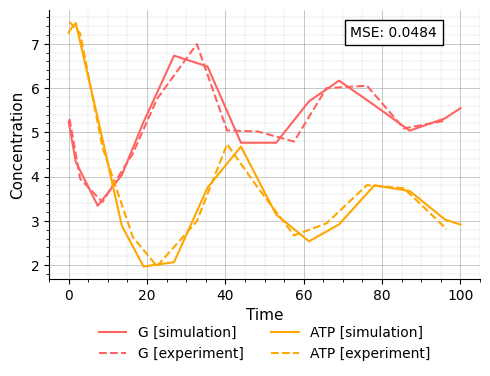

In [7]:
# | fig-align: center
# | fig-cap: Simulation with optimized parameters

mse = objective(res["params"], True, True)
print(f"MSE with Optimized Parameters: {mse:.4f}")

**20% of your assignment grade will be based on the optimized performance you achieve. Let MSE be the mean squared error of the simulation with your optimized parameters (as present in hwparamestim_simulation.xlsx). Your optimization performance grade will be calculated using the following formula: 20*max(min((1.05 - MSE), 1), 0)**